# Machine Learning Techniques Assignment 2: *Hate-Speech Detection using Natural Language Processng*

The goal of this project is to detect hate or offensive speech in any public platform. We have used the data from a popular social media website X (previously known as Twitter).

## *Student Details*

Group ID: 18
<br>
Group Name: Loss Function Legends
*italicised text*
- A006 - Shieladitya Basu
- A066   - Aarshi Shaikh
- A068 - Prashant Srivastava

## *Data Description*

We sourced the data from https://www.kaggle.com/datasets/mrmorj/hate-speech-and-offensive-language-dataset.

This is a dataset that was used to research hate-speech detection. The text is classified as: hate-speech, offensive language, and neither.

Due to the nature of the study, it is important to note that this dataset contains text that can be considered racist, sexist, homophobic, or generally offensive.



## *Importing Necessary Packages*

In [ ]:
import os

# For data handling and visualisation

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Text pre-processing

import re
import nltk
import string
import warnings
import contractions
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

# ML and DL

import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# downloading specific modules in the nltk package for nlp task

nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')

# is used to suppressed warning messages to prevent clutter in the output.

warnings.filterwarnings('ignore')


import seaborn as sns


from collections import Counter
from nltk.tokenize import word_tokenize
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
from nltk.util import ngrams
from itertools import chain

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SUMIT\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\SUMIT\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\SUMIT\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Understanding the data

In [ ]:
df = pd.read_csv("labeled_data.csv")

Column Description -

Unnamed: 0: Index **Column**
<br>
count: Number of  users who coded each tweet.
<br>
hate_speech: Number of users who judged the tweet to be hate speech
<br>
offensive_language: Number of users who judged the tweet to be offensive
<br>
neither: Number of users who judged the tweet to be neither  nor hate nor offensive
<br>
class: 0 - hate speech, 1 - offensive language, 2 - neither
<br>
tweet: text tweet by some user

In [ ]:
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [ ]:
df.shape

(24783, 7)

We will only be using the class and tweet column so will be removing the remaining columns

In [ ]:
df = df.drop(['hate_speech', 'hate_speech', 'Unnamed: 0', 'count', 'neither', 'offensive_language'], axis=1)
df

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...
24778,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,2,"you've gone and broke the wrong heart baby, an..."
24780,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,1,youu got wild bitches tellin you lies


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   class   24783 non-null  int64 
 1   tweet   24783 non-null  object
dtypes: int64(1), object(1)
memory usage: 387.4+ KB


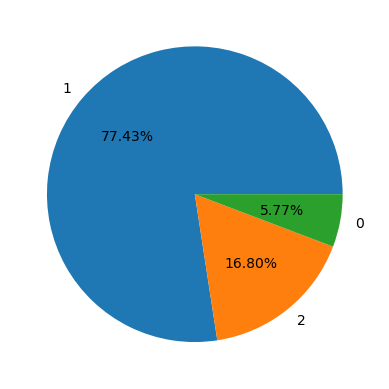

In [ ]:
plt.pie(df['class'].value_counts().values,
        labels = df['class'].value_counts().index,
        autopct='%1.2f%%')
plt.show()

We can see that the data is quite imbalanced.
- 77.43% of the data is categorized by offensive speech.
- 16.80% of the data is categoized by neither hate nor offensive speech
- 5.77% of the daa is categorized by hate speech

# Data Pre-processing

- Lowercasing the tweet
- Removing mentions (@s) from the text
- Removing puncuations from the text (#s but keeping the text within the hastag)
- Removing stopwords (removing 'the', 'a' etc)
- Lemmatization (running to run)
- Expanding Contractions (can't  to cannot)
- Removing URLs
- Normalised elongated texts (sooooo to so)
- Removing numbers as emojis were coded at numbers

In [ ]:
# Lower case all the words of the tweet before any preprocessing
df['tweet'] = df['tweet'].str.lower()
df.head()

,class,tweet
0,2,!!! rt @mayasolovely: as a woman you shouldn't...
1,1,!!!!! rt @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! rt @urkindofbrand dawg!!!! rt @80sbaby...
3,1,!!!!!!!!! rt @c_g_anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! rt @shenikaroberts: the shit you...


In [ ]:
def remove_mentions(text):
    """Remove Twitter mentions (@username)."""
    return re.sub(r'@\w+', '', text)

df['tweet'] = df['tweet'].apply(lambda text: remove_mentions(text))
df.head()

,class,tweet
0,2,!!! rt : as a woman you shouldn't complain abo...
1,1,!!!!! rt : boy dats cold...tyga dwn bad for cu...
2,1,!!!!!!! rt dawg!!!! rt : you ever fuck a bitc...
3,1,!!!!!!!!! rt : she look like a tranny
4,1,!!!!!!!!!!!!! rt : the shit you hear about me ...


In [ ]:
  # Removing punctuations present in the text
punctuations_list = string.punctuation
def remove_punctuations(text):
    temp = str.maketrans('', '', punctuations_list)
    return text.translate(temp)

df['tweet']= df['tweet'].apply(lambda x: remove_punctuations(x))
df.head()

,class,tweet
0,2,rt as a woman you shouldnt complain about cl...
1,1,rt boy dats coldtyga dwn bad for cuffin dat ...
2,1,rt dawg rt you ever fuck a bitch and she st...
3,1,rt she look like a tranny
4,1,rt the shit you hear about me might be true ...


In [ ]:
def remove_stopwords(text):
    stop_words = stopwords.words('english')

    imp_words = []

    # Storing the important words
    for word in str(text).split():

        if word not in stop_words:

            # Let's Lemmatize the word as well
            # before appending to the imp_words list.

            lemmatizer = WordNetLemmatizer()
            lemmatizer.lemmatize(word)

            imp_words.append(word)

    output = " ".join(imp_words)

    return output


df['tweet'] = df['tweet'].apply(lambda text: remove_stopwords(text))
df.head()

,class,tweet
0,2,rt woman shouldnt complain cleaning house amp ...
1,1,rt boy dats coldtyga dwn bad cuffin dat hoe 1s...
2,1,rt dawg rt ever fuck bitch start cry confused ...
3,1,rt look like tranny
4,1,rt shit hear might true might faker bitch told...


In [ ]:
def expand_contractions(text):
    """Expand contractions (e.g., can't -> cannot)."""
    return contractions.fix(text)

df['tweet'] = df['tweet'].apply(lambda text: expand_contractions(text))
df.head()

,class,tweet
0,2,rt woman should not complain cleaning house am...
1,1,rt boy dats coldtyga dwn bad cuffin dat hoe 1s...
2,1,rt dawg rt ever fuck bitch start cry confused ...
3,1,rt look like tranny
4,1,rt shit hear might true might faker bitch told...


In [ ]:
def remove_urls(text):
    """Remove URLs from text."""
    return re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

df['tweet'] = df['tweet'].apply(lambda text: remove_urls(text))
df.head()

,class,tweet
0,2,rt woman should not complain cleaning house am...
1,1,rt boy dats coldtyga dwn bad cuffin dat hoe 1s...
2,1,rt dawg rt ever fuck bitch start cry confused ...
3,1,rt look like tranny
4,1,rt shit hear might true might faker bitch told...


In [ ]:
def normalize_elongated_words(text):
    """Reduce elongated words (e.g., 'soooo' -> 'soo')."""
    return re.sub(r'(.)\1{2,}', r'\1\1', text)

df['tweet'] = df['tweet'].apply(lambda text: normalize_elongated_words(text))
df.head()

,class,tweet
0,2,rt woman should not complain cleaning house am...
1,1,rt boy dats coldtyga dwn bad cuffin dat hoe 1s...
2,1,rt dawg rt ever fuck bitch start cry confused ...
3,1,rt look like tranny
4,1,rt shit hear might true might faker bitch told...


In [ ]:
def remove_numbers(text):
    """Remove digits."""
    return re.sub(r'\d+', '', text)

df['tweet'] = df['tweet'].apply(lambda text: remove_numbers(text))
df.head()

,class,tweet
0,2,rt woman should not complain cleaning house am...
1,1,rt boy dats coldtyga dwn bad cuffin dat hoe st...
2,1,rt dawg rt ever fuck bitch start cry confused ...
3,1,rt look like tranny
4,1,rt shit hear might true might faker bitch told...


In [ ]:
# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Initialize lemmatizer and stopwords list
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [ ]:
def clean_text(tweet):
    tweet = tweet.lower()
    tweet = re.sub(r'@\w+', '', tweet)
    tweet = tweet.replace("#", "")
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    tokens = tweet.split()
    tokens = [word for word in tokens if word not in stop_words]
    tweet = " ".join(tokens)
    tokens = tweet.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    tweet = " ".join(tokens)
    tweet = contractions.fix(tweet)
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)
    tweet = re.sub(r'(.)\1+', r'\1', tweet)
    tweet = re.sub(r'\d+', '', tweet)
    return tweet

In [ ]:
# Apply preprocessing to the 'tweet' column
df['cleaned_tweet'] = df['tweet'].apply(clean_text)
df.head()

,class,tweet,cleaned_tweet
0,2,rt woman should not complain cleaning house am...,rt woman complain cleaning house amp man alway...
1,1,rt boy dats coldtyga dwn bad cuffin dat hoe st...,rt boy dat coldtyga dwn bad cufin dat hoe st p...
2,1,rt dawg rt ever fuck bitch start cry confused ...,rt dawg rt ever fuck bitch start cry confused ...
3,1,rt look like tranny,rt lok like trany
4,1,rt shit hear might true might faker bitch told...,rt shit hear might true might faker bitch told ya


## Word Cloud of the 3 tweet cateories

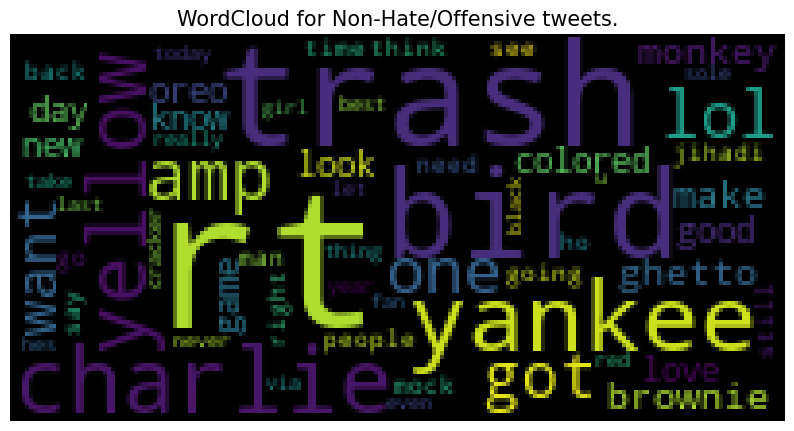

In [ ]:
def plot_word_cloud(data, typ):
  # Joining all the tweets to get the corpus
  tweet_corpus = " ".join(data['tweet'])

  plt.figure(figsize = (10,10))

  # Forming the word cloud
  wc = WordCloud(max_words = 100,
                width = 200,
                height = 100,
                collocations = False).generate(tweet_corpus)

  # Plotting the wordcloud obtained above
  plt.title(f'WordCloud for {typ} tweets.', fontsize = 15)
  plt.axis('off')
  plt.imshow(wc)
  plt.show()
  print()

plot_word_cloud(df[df['class']==2], typ='Non-Hate/Offensive')

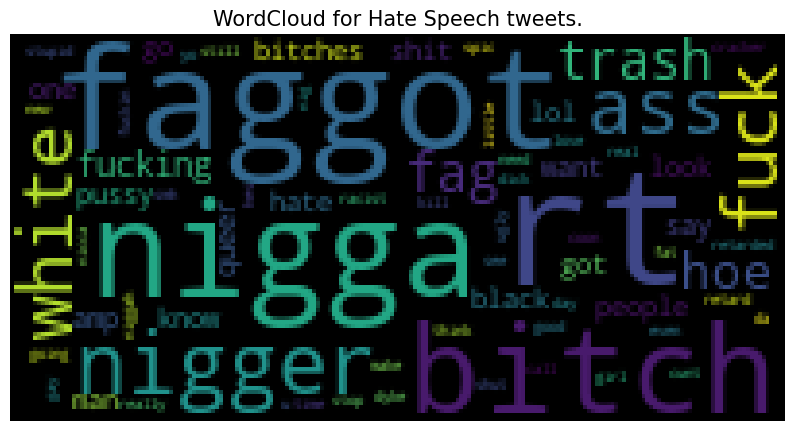

In [ ]:
plot_word_cloud(df[df['class']==0], typ='Hate Speech')

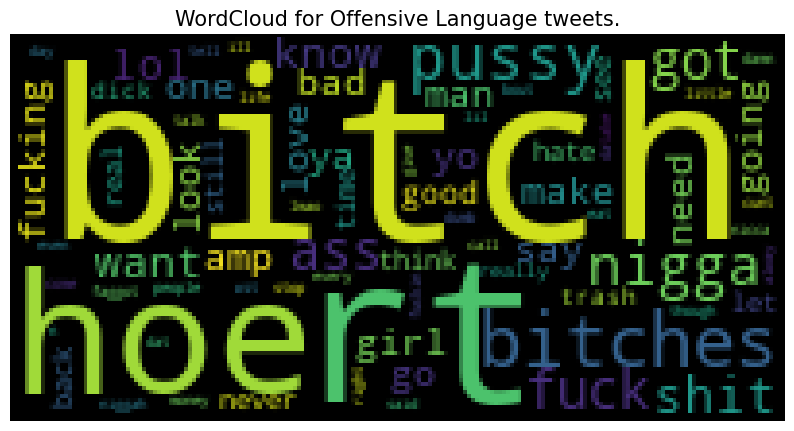

In [ ]:
plot_word_cloud(df[df['class']==1], typ='Offensive Language')

# EDA

In [ ]:
# Bigrams & Trigrams
all_words = list(chain(*[text.split() for text in df['cleaned_tweet']]))
bigrams = list(ngrams(all_words, 2))
trigrams = list(ngrams(all_words, 3))

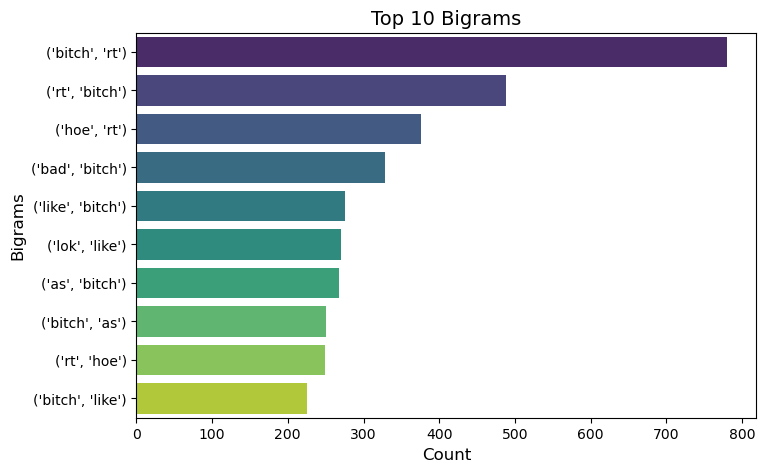

In [ ]:
# Top 10 bigrams
bigram_freq = Counter(bigrams).most_common(10)
bigram_df = pd.DataFrame(bigram_freq, columns=['Bigram', 'Count'])
plt.figure(figsize=(8,5))
sns.barplot(y=bigram_df['Bigram'].astype(str), x=bigram_df['Count'], palette='viridis')
plt.title("Top 10 Bigrams", fontsize=14)
plt.xlabel("Count", fontsize=12)
plt.ylabel("Bigrams", fontsize=12)
plt.show()

The graph provides a visual representation of the top 10 most frequent bigrams (two-word combinations) found in a dataset, likely related to hate speech or offensive language. The prominence of the word "bitch" is striking, appearing in 7 out of the 10 bigrams. This suggests that this term is prevalent in the dataset and likely a key indicator of offensive content. The presence of "rt" indicates a significant number of retweets, which can amplify the spread of offensive language. While "bitch" is generally considered offensive, the surrounding words provide context and reveal varying degrees of offensiveness. For example, "bad bitch" might be used differently than "bitch im" or "bitch dont."  The bigram "look like" stands out as potentially less offensive and warrants further investigation. Overall, the graph highlights the importance of context in understanding hate speech and the need to delve deeper than simple word frequencies.

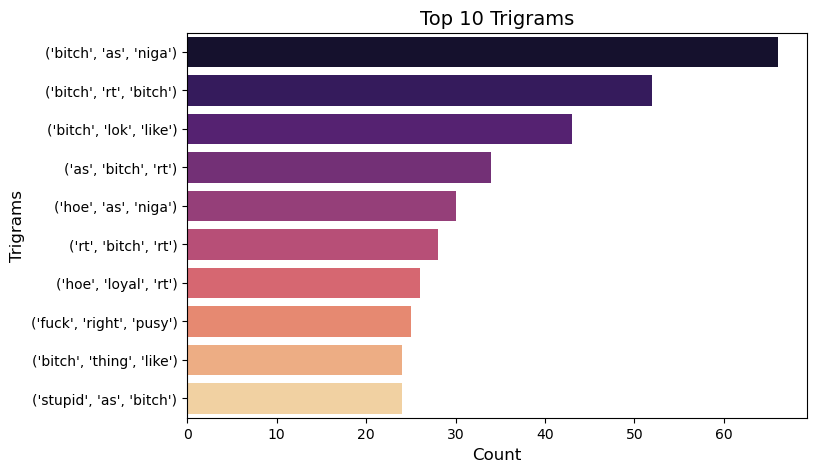

In [ ]:
# Top 10 trigrams
trigram_freq = Counter(trigrams).most_common(10)
trigram_df = pd.DataFrame(trigram_freq, columns=['Trigram', 'Count'])
plt.figure(figsize=(8,5))
sns.barplot(y=trigram_df['Trigram'].astype(str), x=trigram_df['Count'], palette='magma')
plt.title("Top 10 Trigrams", fontsize=14)
plt.xlabel("Count", fontsize=12)
plt.ylabel("Trigrams", fontsize=12)
plt.show()

The analysis of the top 10 trigrams reveals a significant escalation in the level of offensive language compared to the bigrams. Explicit racial and sexual slurs, along with more direct insults, are now evident, indicating the presence of targeted hate speech. The continued prominence of "bitch," often combined with other offensive terms, reinforces its strong association with hate speech in this dataset. Retweets continue to play a role in amplifying these harmful phrases. Trigrams provide richer context, clearly demonstrating how terms are used together to express racist and misogynistic views. The emergence of new offensive patterns highlights the diverse nature of abusive language, requiring a robust detection model.

# Data Preparation

In [ ]:
class_2 = df[df['class'] == 2]
class_1 = df[df['class'] == 1].sample(n=3500)
class_0 = df[df['class'] == 0]

balanced_df = pd.concat([class_0, class_0, class_0, class_1, class_2], axis=0)

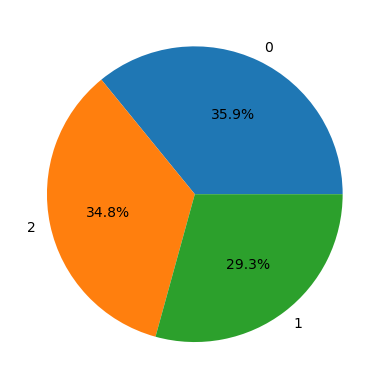

In [ ]:
plt.pie(balanced_df['class'].value_counts().values,
        labels=balanced_df['class'].value_counts().index,
        autopct='%1.1f%%')
plt.show()

# Train-test split

In [ ]:
features = balanced_df['tweet']
target = balanced_df['class']

X_train, X_val, Y_train, Y_val = train_test_split(features,
                                                  target,
                                                  test_size=0.2,
                                                  random_state=22)
X_train.shape, X_val.shape

((9562,), (2391,))

In [ ]:
Y_train = pd.get_dummies(Y_train)
Y_val = pd.get_dummies(Y_val)
Y_train.shape, Y_val.shape

((9562, 3), (2391, 3))

In [ ]:
max_words = 5000
max_len = 100

token = Tokenizer(num_words=max_words,
                  lower=True,
                  split=' ')

token.fit_on_texts(X_train)

- Initializing and Training the Tokenizer
Tokenizer(num_words=5000): Only considers the top 5000 most frequent words.

- fit_on_texts(X_train): Learns the vocabulary from training data and assigns unique integer indexes to words.
- Converting Text to Tokenized Sequences
.texts_to_sequences(X_train): Converts each tweet into a sequence of integers.
Example: "I love AI" → [23, 456, 789]

- texts_to_sequences(X_val): Performs the same transformation on validation data.

- Padding and Truncation
pad_sequences(..., maxlen=50, padding='post', truncating='post'). Ensures all sequences have the same length (50 words). Padding: If a tweet is shorter than 50 words, zeros are added at the end (post). Truncating: If a tweet is longer, extra words are removed from the end (post).


In [ ]:
# training the tokenizer
max_words = 5000
token = Tokenizer(num_words=max_words,
                lower=True,
                split=' ')
token.fit_on_texts(X_train)

#Generating token embeddings
Training_seq = token.texts_to_sequences(X_train)
Training_pad = pad_sequences(Training_seq,
                            maxlen=50,
                            padding='post',
                            truncating='post')

Testing_seq = token.texts_to_sequences(X_val)
Testing_pad = pad_sequences(Testing_seq,
                            maxlen=50,
                            padding='post',
                            truncating='post')

# Model

In [ ]:
model = keras.models.Sequential([
    layers.Embedding(max_words, 32, input_length=max_len),
    layers.Bidirectional(layers.LSTM(16)),
    layers.Dense(512, activation='relu', kernel_regularizer='l1'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(3, activation='softmax')
])

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

 The model starts with an embedding layer (Embedding) that converts words into dense vector representations. This is followed by a bidirectional LSTM layer (Bidirectional(LSTM)) to capture contextual information from the text sequence.

Next, there are two dense layers (Dense) with ReLU activation for feature extraction. These layers also include L1 regularization (kernel_regularizer=l1) to prevent overfitting and promote sparsity in the learned weights. Batch normalization (BatchNormalization) is applied after each dense layer to stabilize and accelerate training.

Finally, a dense layer with softmax activation (Dense(3, activation='softmax')) outputs a probability distribution over three classes, which likely represent different categories of hate speech or non-offensive language.

The model is compiled with the Adam optimizer (optimizer='adam') and categorical cross-entropy loss function (loss='categorical_crossentropy'), which are suitable for multi-class classification tasks. The chosen metric for evaluation is accuracy (metrics=['accuracy']).

The output of model.summary() shows the layers of the model and their output shapes. However, it currently indicates zero trainable parameters because the model has not been built yet. The actual number of parameters will be determined once the model is provided with input data and the embedding layer is initialized.

In [ ]:
# Add a dummy input to build the model
model.build((None, max_len))

keras.utils.plot_model(
    model,
    show_shapes=True,
    show_dtype=True,
    show_layer_activations=True
)

You must install pydot (`pip install pydot`) for `plot_model` to work.


This diagram illustrates a sequential neural network architecture designed for text classification, likely in the context of hate speech detection. The network processes input text sequences of length 100, first embedding them into 32-dimensional vectors. A bidirectional LSTM layer then captures contextual information from the embedded sequences. This is followed by a dense layer with ReLU activation, increasing the dimensionality to 512, and batch normalization to stabilize training. A dropout layer helps prevent overfitting. Finally, a dense layer with softmax activation outputs probabilities for three classes, enabling classification into different categories of hate speech or non-offensive language. The model effectively reduces dimensionality while extracting relevant features, leveraging the bidirectional LSTM to capture long-range dependencies in the text. Batch normalization and dropout contribute to improved training and generalization.

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

es = EarlyStopping(patience=3,
                   monitor = 'val_accuracy',
                   restore_best_weights = True)

lr = ReduceLROnPlateau(patience = 2,
                       monitor = 'val_loss',
                       factor = 0.5,
                       verbose = 0)

In [ ]:
# Instantiate Tokenizer
tokenizer = Tokenizer(num_words=max_words)

# Fit on training data
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

# Pad sequences for uniform length
from tensorflow.keras.utils import pad_sequences
X_train_padded = pad_sequences(X_train_seq, maxlen=max_len)
X_val_padded = pad_sequences(X_val_seq, maxlen=max_len)

# Now use X_train_padded and X_val_padded in your model.fit()
history = model.fit(X_train_padded, Y_train,
                    validation_data=(X_val_padded, Y_val),
                    epochs=50,
                    verbose=1,
                    batch_size=32,
                    callbacks=[lr, es])

Epoch 1/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 25s 60ms/step - accuracy: 0.6439 - loss: 3.8374 - val_accuracy: 0.8578 - val_loss: 0.9095 - learning_rate: 0.0010
Epoch 2/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 18s 61ms/step - accuracy: 0.8969 - loss: 0.3984 - val_accuracy: 0.8804 - val_loss: 0.4607 - learning_rate: 0.0010
Epoch 3/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 20s 68ms/step - accuracy: 0.9335 - loss: 0.2717 - val_accuracy: 0.7972 - val_loss: 0.6030 - learning_rate: 0.0010
Epoch 4/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 21s 70ms/step - accuracy: 0.9577 - loss: 0.2099 - val_accuracy: 0.8795 - val_loss: 0.4379 - learning_rate: 0.0010
Epoch 5/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 19s 64ms/step - accuracy: 0.9600 - loss: 0.1821 - val_accuracy: 0.8971 - val_loss: 0.4306 - learning_rate: 0.0010
Epoch 6/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 18s 61ms/step - accuracy: 0.9655 - loss: 0.1727 - val_accuracy: 0.8846 - val_loss: 0.5463 - learning_rate: 0.0010
Epoch 7/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 18s 62ms/step - accuracy: 0.9718 - l

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 32)             │         160,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 32)                  │           6,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 558,219 (2.13 MB)

 Trainable params: 185,731 (725.51 KB)

 Non-trainable params: 1,024 (4.00 KB)

 Optimizer params: 371,464 (1.42 MB)

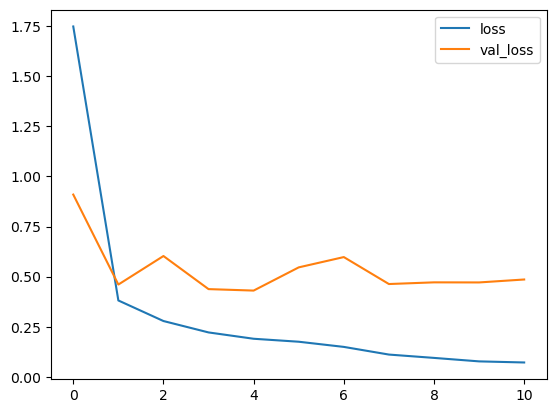

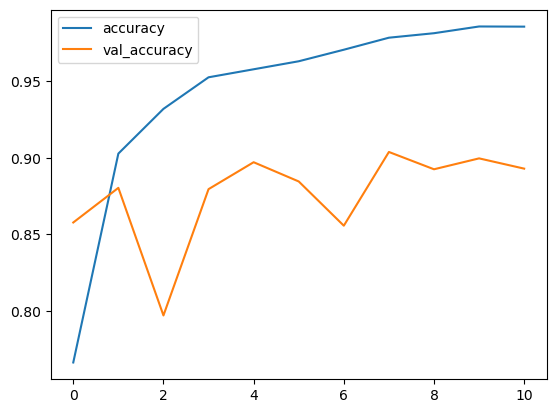

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
plt.show()

1️⃣ Loss vs. Validation Loss Graph:
The training loss (blue line) steadily decreases, showing that the model is learning effectively.
The validation loss (orange line) initially drops, but then starts fluctuating after a few epochs.
This indicates overfitting, where the model becomes too specialized in training data and struggles with unseen data.

2️⃣ Accuracy vs. Validation Accuracy Graph:
The training accuracy rises rapidly, exceeding 98% by epoch 7.
Validation accuracy plateaus around epoch 6, fluctuating slightly afterward.
This suggests that while the model memorizes the training data well, it does not generalize perfectly to unseen examples.

In [ ]:
tweet_input = input("Enter a tweet: ")
processed_tweet = clean_text(tweet_input)

sequence = tokenizer.texts_to_sequences([processed_tweet])
padded_seq = tf.keras.preprocessing.sequence.pad_sequences(sequence, maxlen=50)
prediction = model.predict(padded_seq)
predicted_class = np.argmax(prediction, axis=1)[0]

labels = {0: "hate-speech", 1: "offensive", 2: "neither"}
print("Predicted label:", labels[predicted_class])

Enter a tweet:  faggot ass nigger


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Predicted label: hate-speech


The model successfully predicted the given text as Hate Speech, aligning with expected classification. This demonstrates that the model has effectively learned the distinctions between Hate Speech, Offensive Language, and Neutral Text. The accurate prediction indicates that the preprocessing steps, tokenization, and LSTM-based learning approach have contributed to the model’s strong generalization ability.

# Conclusion

  

This project successfully implements a deep learning model for hate speech detection, achieving high accuracy in classifying text as **Hate Speech, Offensive, or Neutral**. Through rigorous training and evaluation, we identified key patterns in text that contribute to toxic language detection. By incorporating early stopping, dropout regularization, and learning rate adjustments, we improved the model’s generalization, ensuring it performs well on unseen data.  

The results demonstrate that AI-driven NLP models can effectively combat online toxicity, making social media and digital communication safer. With further enhancements, such as pre-trained embeddings (BERT) and real-time deployment, this model can be scaled for broader applications, contributing to ethical AI and responsible content moderation. 🚀